# Data Preparation

The first step in this project is actually getting the raw stock data from Alpha Vantage and processing into a form ready for training.

Before starting this process you must get an API key from this [site](https://www.alphavantage.co/support/#api-key).

## 1. Load some necessary modules

In [1]:
# You only need to run this once on a SageMaker instance or on your PC
# If you haven't run it yet, please uncomment and run.
# !pip install alpha_vantage

In [46]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pandas_datareader import data
import pickle
import random
from scipy.optimize import minimize_scalar
import seaborn as sns
import time
import yaml

from alpha_vantage.timeseries import TimeSeries
sns.set()
%matplotlib inline

## 2. Read the user defined settings

In [39]:
with open('settings.yml') as f:
    settings = yaml.safe_load(f)

## 3. Download the stock history
Note you have to manually enter your Alpha Vantage API key in the following cell.  It is unique to each user and is limited to 5 API requests per minute and 500 requests per day, so please don't use someone else's key.

In [40]:
# Set your API key
api_key = 'AIM9J0PA8YV2A12F'

# Format connection
ts = TimeSeries(key=api_key, output_format='pandas')

# Read saved data if it exists
if os.path.isfile('stock-data.pkl'):
    saved_stocks = pd.read_pickle('stock-data.pkl')
    saved_stock_names = saved_stocks.columns.to_list()
else:
    saved_stock_names = []
    
# To avoid hitting the 5 requests per minute, we only pull 1 per 12 sec
times = []
stocks = []
failed = []
for ticker in settings['tickers']:
    if ticker in saved_stock_names:
        stocks.append(saved_stocks.loc[:, [ticker]])
    else:
        if len(times) >= 5:
            delta = 61 - (time.time() - times[-5])
            if delta > 0:
                print("Taking a {:.0f}s break to avoid 5 req/min limit.".format(delta))
                time.sleep(delta)
        
        print("Reading {} from API.".format(ticker))
        try:
            data, _ = ts.get_daily_adjusted(symbol=ticker, outputsize='full')
            data = data.rename(columns={'5. adjusted close': ticker})
            stocks.append(data.loc[settings['data_end']:settings['data_start'], [ticker]])
        except:
            print("\tFailed to pull {} from API.".format(ticker))
            failed.append(ticker)
        times.append(time.time())
stocks = pd.concat(stocks, axis=1)
stocks.to_pickle('stock-data.pkl')
if len(failed) > 0:
    print("Failed to get following tickers from API:")
    print(failed)

Reading SPY from API.


Plot the data to visually check for bad data.  You may want to manually play with the plotting to find data of interest.

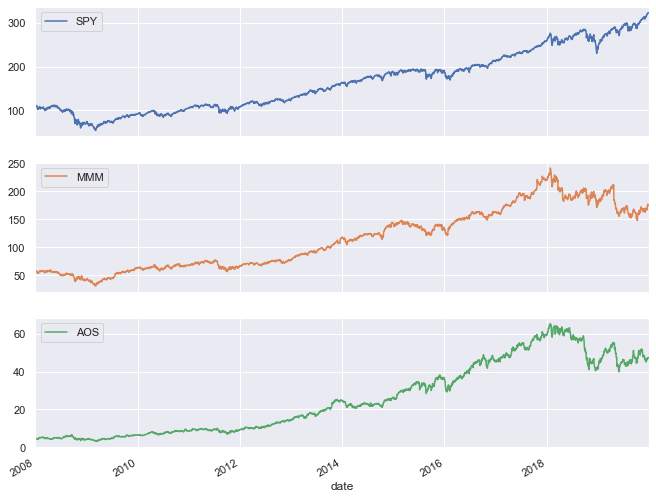

In [41]:
axes = stocks.plot(figsize=(11, 3*stocks.shape[1]), subplots=True)
plt.show()

First thing to notice is not all stocks have data for the full date range.  Since we need a full dataset to train, we will delete these stocks.

In [42]:
# Here are the stocks with NAN values.  Make sure this matches the plots above.
print(stocks.columns[stocks.isna().any()])
print("\nThere are {} stocks that lack data.".format(sum(stocks.isna().any())))

Index([], dtype='object')

There are 0 stocks that lack data.


In [43]:
# Now we delete the imcomplete stocks
stocks = stocks.loc[:, ~stocks.isna().any()]
stocks.shape

(3022, 3)

If you see any data with drop outs, you may wish to reload to see if the source is defective or if there was an issue in the download.  
I will also 'fill' any missing data with a linear interpolation.

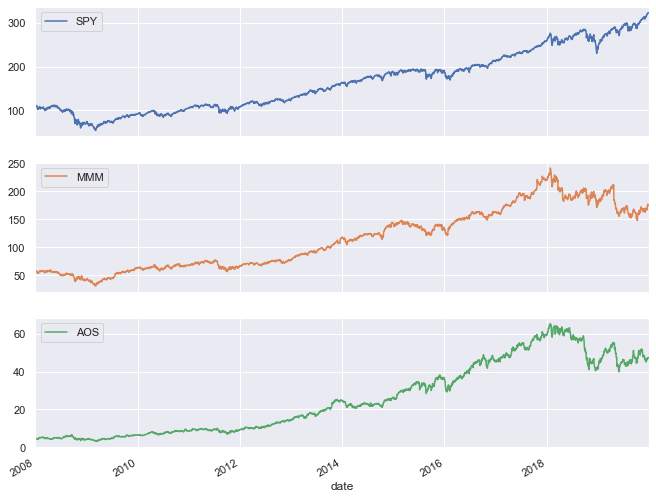

In [47]:
stocks = stocks.replace(0, np.nan).interpolate()
_ = stocks.plot(figsize=(11, 3*stocks.shape[1]), subplots=True)
plt.show()

**Now that's a pretty dataset!!!**

## 4. Create the true signals that we will try to predict

To create the true signals we require two important settings.  First is the `embedding_days` or `k` in most literature.  So if today is time `t`, we will make our prediction based on the data over the interval of `t-k` to `t` inclusively.  The larger the `k` embedding, the more data supporting the prediction.  It should also be noted that during the first `k` days in our dataset we can not make a prediction, since there isn't `k` days of previous data.

The second important setting is the `prediction_days` or `dt`, which is actually a list of days that you want to predict into the future.  So at time `t` we will try to predict if the return on the asset will fall into 1 of the following 5 categories; very bad, bad, neutral, good, very good at time `t + dt`.  To find the return values that demarks the boundaies between these five categoires we will mine them from the training data.  We will look at the returns for all assets over each time interval `dt` and select boundaries so we have 20% of the returns in the neutral bin, which is symmetric about 0 and then have the positive returns split between good and very good.  The negative returns are also split equally between bad and very bad.

Another minor data cleaning step is limiting the return to +/-100%.  Anything above this for such short times lines are outlyers are certainly not something we can predict. 

Combining `k` and `dt` we see that our training data shrinks from the total number of days `n` to `n - k - max(dt)` days with true prediction data available.

### Determine the actual rates of return for each dt

In [48]:
# Calculate the log returns and clip to -1 and 1
actual_returns = {}
cleaned_returns = {}
for dt in settings['prediction_days']:
    actual_returns[dt] = (np.log(stocks) - np.log(stocks.shift(dt))).clip(-1, 1)
    x = actual_returns[dt].to_numpy().flatten()
    cleaned_returns[dt] = x[~np.isnan(x)]

### Determine the classification demarkations

In [59]:
# Little to determine how close the percentage of neutral returns is to the target
def dp_neutral(r_neutral, returns, target):
    neutral = np.sum((returns > -r_neutral) & (returns < r_neutral))
    return np.abs(target -  neutral / returns.shape[0])

# Little to determine see how close the good and very good bins are in size
def dp_good(r_very_good, returns, r_neutral):
    good = np.sum((returns >= r_neutral) & (returns < r_very_good))
    very_good = np.sum(returns >= r_very_good)    
    return np.abs(good - very_good)

# Little to determine see how close the bad and very bad bins are in size
def dp_bad(r_very_bad, returns, r_neutral):
    bad = np.sum((returns <= -r_neutral) & (returns > r_very_bad))
    very_bad = np.sum(returns <= r_very_bad)    
    return np.abs(bad - very_bad)

# Optimize the limits to get the desired divisions
neutral_percentage = 0.2
boundaries = pd.DataFrame(columns=['neutral', 'bad', 'good'], index=settings['prediction_days'])
for dt in settings['prediction_days']:
    
    # Get neutral boundary
    res = minimize_scalar(dp_neutral, args=(cleaned_returns[dt], neutral_percentage), 
                          bounds=(0.0, 0.05), method='bounded')
    boundaries.loc[dt, 'neutral'] = res.x

    # Get good/very good boundary
    res = minimize_scalar(dp_good, args=(cleaned_returns[dt], boundaries.loc[dt, 'neutral']), 
                          bounds=(boundaries.loc[dt, 'neutral'], 0.1), method='bounded')
    boundaries.loc[dt, 'good'] = res.x

    # Get bad/very bad boundary
    res = minimize_scalar(dp_bad, args=(cleaned_returns[dt], boundaries.loc[dt, 'neutral']), 
                          bounds=(-0.1, -boundaries.loc[dt, 'neutral']), method='bounded')
    boundaries.loc[dt, 'bad'] = res.x    

In [60]:
# Just a little sanity check on the boundaries
for dt in settings['prediction_days']:
    very_bad = np.sum(cleaned_returns[dt] <= boundaries.loc[dt, 'bad'])    
    bad = np.sum((cleaned_returns[dt] <= -boundaries.loc[dt, 'neutral']) & 
                 (cleaned_returns[dt] > boundaries.loc[dt, 'bad']))
    neutral = np.sum((cleaned_returns[dt] > -boundaries.loc[dt, 'neutral']) & 
                     (cleaned_returns[dt] < boundaries.loc[dt, 'neutral']))
    good = np.sum((cleaned_returns[dt] >= boundaries.loc[dt, 'neutral']) & 
                  (cleaned_returns[dt] < boundaries.loc[dt, 'good']))
    very_good = np.sum(cleaned_returns[dt] >= boundaries.loc[dt, 'good'])    
    
    tmp_str = "Distribution in {} prediction days with boundaries [{:.1f}%, {:.1f}%, {:.1f}%]."
    print(tmp_str.format(dt, 100*boundaries.loc[dt, 'bad'], 100*boundaries.loc[dt, 'neutral'], 
                         100*boundaries.loc[dt, 'good']))
    print("\t{:.1f}% are very bad.".format(100 * very_bad / cleaned_returns[dt].shape[0]))
    print("\t{:.1f}% are bad.".format(100 * bad / cleaned_returns[dt].shape[0]))
    print("\t{:.1f}% are neutral.".format(100 * neutral / cleaned_returns[dt].shape[0]))
    print("\t{:.1f}% are good.".format(100 * good / cleaned_returns[dt].shape[0]))
    print("\t{:.1f}% are very good.".format(100 * very_good / cleaned_returns[dt].shape[0]))

Distribution in 1 prediction days with boundaries [-0.9%, 0.2%, 0.9%].
	18.1% are very bad.
	18.2% are bad.
	20.0% are neutral.
	21.8% are good.
	21.8% are very good.
Distribution in 5 prediction days with boundaries [-2.2%, 0.6%, 2.0%].
	16.3% are very bad.
	16.3% are bad.
	20.0% are neutral.
	23.7% are good.
	23.7% are very good.
Distribution in 21 prediction days with boundaries [-4.8%, 1.4%, 4.2%].
	13.7% are very bad.
	13.7% are bad.
	20.0% are neutral.
	26.3% are good.
	26.3% are very good.


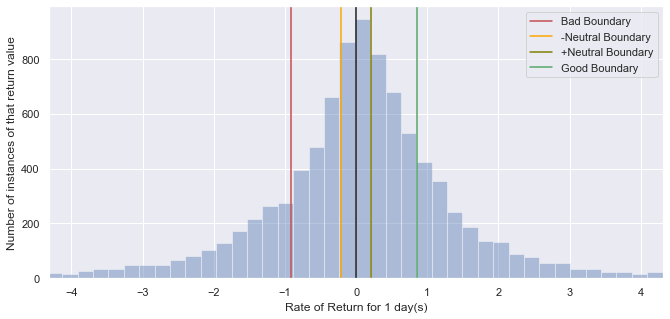

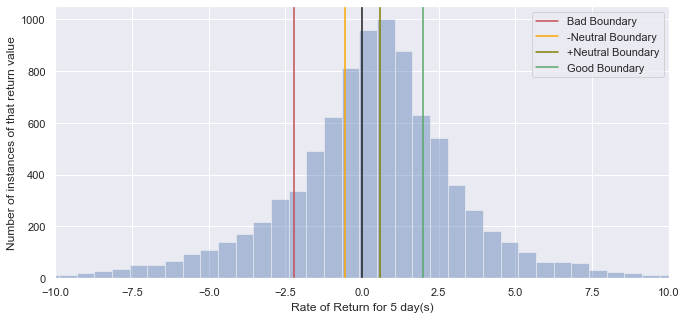

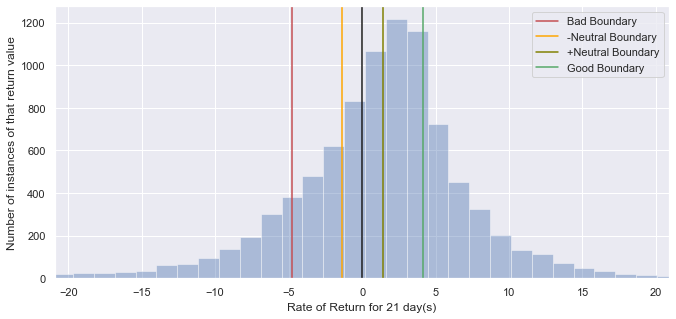

In [61]:
# Plot the return distributions for reference (great way to find errors)
sns.set(color_codes=True)
for dt in settings['prediction_days']:
    fig, ax = plt.subplots(figsize=(11, 5))
    ax.set(xlim=(-boundaries.loc[dt, 'good'] * 500, boundaries.loc[dt, 'good'] * 500))
    
    n_bins = int((cleaned_returns[dt].max() - cleaned_returns[dt].min()) / boundaries.loc[dt, 'neutral'])
    sns.distplot(100*cleaned_returns[dt], ax=ax, kde=False, bins=n_bins)

    plt.axvline(x=100*boundaries.loc[dt, 'bad'], color='r', label='Bad Boundary')
    plt.axvline(x=-100*boundaries.loc[dt, 'neutral'], color='orange', label='-Neutral Boundary')
    plt.axvline(x=100*boundaries.loc[dt, 'neutral'], color='olive', label='+Neutral Boundary')
    plt.axvline(x=100*boundaries.loc[dt, 'good'], color='g', label='Good Boundary')
    plt.axvline(x=0.0, color='k')
    plt.legend()
    
    plt.xlabel('Rate of Return for {} day(s)'.format(dt))
    plt.ylabel('Number of instances of that return value')
    plt.show()

### Create true classifications with new boundaries
s = Return values shifted by `dt` (at time = `t` the return was calculated at `t+dt`)
c = Temporary Numpy array used to generate the classifications
We assign classifications of [0, 0.25, 0.5, 0.75 and 1.0] so the target data is pre normalized.

In [62]:
classification = {}
for dt in settings['prediction_days']:
    s = actual_returns[dt].iloc[dt:, :]
    c = np.where((s >= boundaries.loc[dt, 'bad']) & 
                 (s < -boundaries.loc[dt, 'neutral']), 0.25, np.zeros_like(s.values))
    c = np.where((s >= -boundaries.loc[dt, 'neutral']) & 
                 (s <= boundaries.loc[dt, 'neutral']), 0.5, c)
    c = np.where((s > boundaries.loc[dt, 'neutral']) & 
                 (s <= boundaries.loc[dt, 'good']), 0.75, c)
    c = np.where(s > boundaries.loc[dt, 'good'], 1.0, c)
    classification[dt] = pd.DataFrame(c, index=actual_returns[dt].index[:-dt], columns=s.columns)

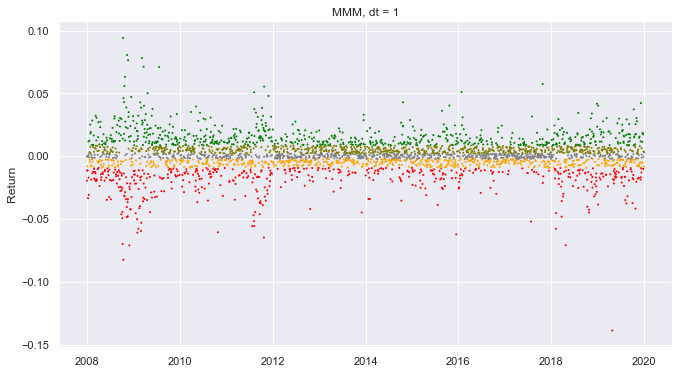

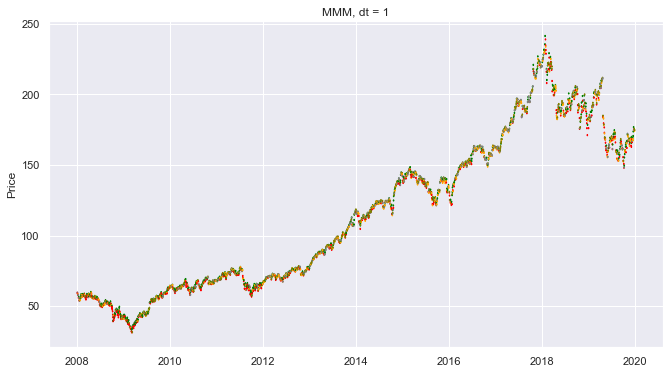

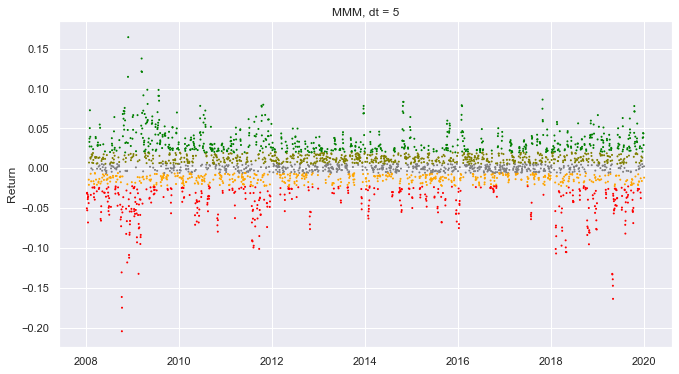

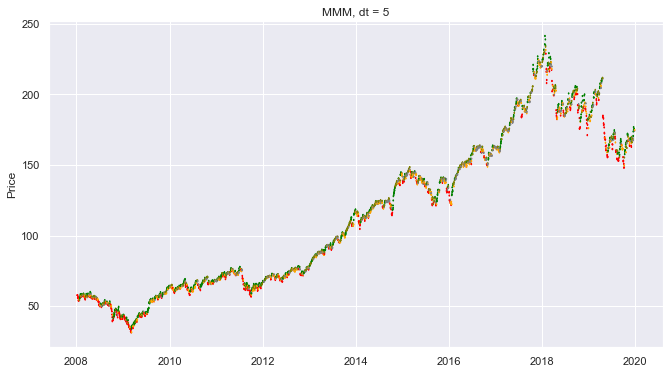

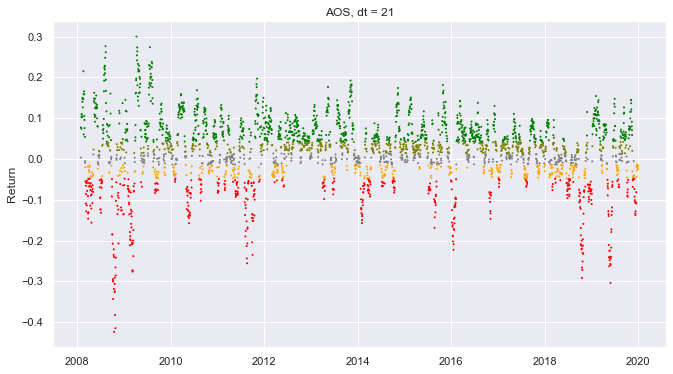

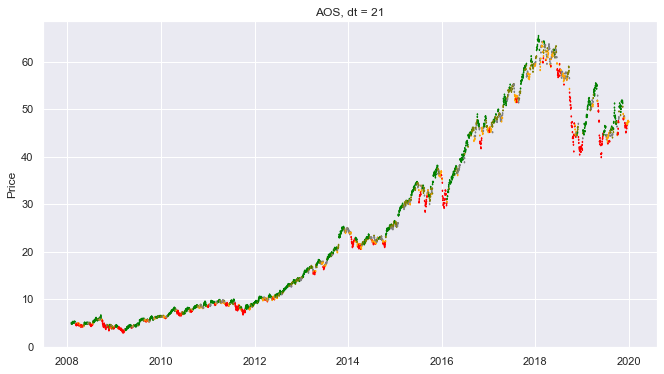

In [63]:
# Quick sanity check on the classification
for dt in settings['prediction_days']:
    
    # Randomly select asset to view
    i = random.randrange(stocks.shape[1])

    # Set the color based on the classification
    colour = deepcopy(classification[dt].iloc[:, i])
    colour.loc[colour == 0.00] = 'red'
    colour.loc[colour == 0.25] = 'orange'
    colour.loc[colour == 0.50] = 'grey'
    colour.loc[colour == 0.75] = 'olive'
    colour.loc[colour == 1.00] = 'green'

    # Plot the shifted returns
    fig, ax = plt.subplots(figsize=(11, 6))
    s_r = actual_returns[dt].iloc[dt:, i]
    ax.scatter(s_r.index, s_r.values, color=colour, label='Returns', marker='o', s=1)
    ax.set_ylabel('Return')
    ax.set_title("{}, dt = {}".format(s_r.name, dt))
    plt.show()
    
    # Plot the shifted prices
    fig, ax = plt.subplots(figsize=(11, 6))
    s_p = stocks.iloc[dt:, i]
    ax.scatter(s_p.index, s_p.values, color=colour, label='Prices', marker='d', s=1)
    ax.set_title("{}, dt = {}".format(s_r.name, dt))
    ax.set_ylabel('Price')   
    plt.show()


### Awesome, we now have the classifications for training!
Last step will be to save this data in a clean format for the next notebook to use.

First we have to clip the training data at the end by max(dt) so that we can have a full set of classifications.  We will also have to clip the begining my min(dt) to allow for the return calculation.

We will also be using the returns with the smallest dt values are the training data input.  We use returns instead of the raw stock prices to ensure we have stationary timeseries data.  Consider a stock that is \\$10 to \\$20 over the training period but grows above \\$20 during the prediction.  The model will be seeing new data and will be extrapolating.  Also when we standardize the data, the mean and standard deviation of the returns will be much more meaningful.

We will be using the smallest dt value since these data contains more information than returns based on larger dt values.  We could you multiple dt values as input but it would be repeating information and adding complexity.

Lastly we need to save the mean and standard deviation data to standardize any new data that we receive.

In [67]:
# First lets clip all the data to the same end date for a full training dataset
start = stocks.index[max(settings['prediction_days'])]
end = stocks.index[-max(settings['prediction_days'])-1]
classification_clipped = {}
returns_clipped = {}
stats = {}
for dt in settings['prediction_days']:
    classification_clipped[dt] = classification[dt].loc[start:end, :]
    returns_clipped[dt] = actual_returns[dt].loc[start:end, :]
    
    # Also normalized the input
    stats[dt] = returns_clipped[dt].describe().loc[['mean', 'std'], :]
    returns_clipped[dt] = (returns_clipped[dt] - stats[dt].loc['mean', :]) / stats[dt].loc['std', :]

In [68]:
# And finally save the data for the next training notebook
with open('training-data-raw.pkl', 'wb') as f:
    pickle.dump({'stats': stats, 'x': returns_clipped, 'y':classification_clipped}, 
                f, protocol=pickle.HIGHEST_PROTOCOL)

In [69]:
returns_clipped[dt]

,SPY,MMM,AOS
date,,,
2008-01-31,-1.480748,-1.110209,-0.164136
2008-02-01,-0.955424,-0.446173,0.745591
2008-02-04,-1.214469,-0.579931,0.706756
2008-02-05,-1.263864,-0.701975,1.073117
2008-02-06,-1.417396,-0.545415,1.142445
...,...,...,...
2019-11-22,0.578185,0.612297,-0.826998
2019-11-25,0.655306,0.440890,-0.720746
2019-11-26,0.584039,0.034405,-0.805948
